In [208]:
import pandas as pd
import numpy as np

In [209]:
# pd.set_option('precision',2)
# locale.setlocale( locale.LC_ALL, 'English_United States.1252')
# locale._override_localeconv = {'n_sign_posn':1}

import pandas as pd
import locale

In [210]:
get_ipython().magic('matplotlib inline')
import matplotlib.pylab as plt
import seaborn as sns
# import ggplot as gg
# from ggplot import *
import bokeh as bkh
from bokeh.layouts import row
from bokeh.plotting import figure, show, output_file

In [211]:
# dataset from https://www.kaggle.com/kaggle/sf-salaries
# sf2014
sf = pd.read_csv('data/sf-salaries/Salaries.csv', usecols=[0,1,2,3,4,5,6,7,9,11,12], dtype={3: object, 4: object, 5: object, 6: object, 12: object}, na_values=['Not Provided', 'Not provided', 'not provided'])

Submission Requirements: 
    
Submit links to a Github repository containing a Jupyter notebook. The notebook should contain:

* The questions you asked
* The trends you investigated
* The resulting visualizations and conclusions.


## Defination of the columns:

### Numeric (needs conversion to numeric):
##### 1. BasePay, OvertimePay, OtherPay, Benefits, TotalPay

### Categorical:
##### 1. Id, EmployeeName, JobTitle, Agency, Status


## Starting Analysis

* Agency - Represents a region in the larger datasets.
* BasePay - The base rate of pay for a job or activity, excluding additional payments such as overtime or bonuses.
* Benefits - Employees pension plan, free health insurance, and other benefits.
* EmployeeName - Full Name (we can try to use this to analyze gender discrimination)
* Id - Original order of employees from sf2014 dataset, field does not exist in sf 2015
* JobTitle - Employee position held. (There seem to be differences in naming between datasets.)
* Notes - Empty
* OtherPay - Not sure but I would imagine Bonuses or other 'special' benefits. Could include personal flights on public aircrafts.
* OvertimePay - Time paid at California's's 1.5x base pay for over time.
* Status - Classification as FT (Full Time) or PT (Part Time) employee. Only tracked after 2013.
* TotalPay - BasePay + OvertimePay + OtherPay
* Year - Payroll year

In [212]:
sf.head()

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.0,400184.25,NaN,567595.43,2011,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.6,NaN,335279.91,2011,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.0,56120.71,198306.9,NaN,332343.61,2011,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.6,9737.0,182234.59,NaN,326373.19,2011,San Francisco,NaN


# Questions

* How many employees does San Francisco employ?
* What are the job titles of these employees?
* How much on average does SF pay?
* San Francisco payroll, as well as California, in general have a much higher payroll than other cities of similar size, is there a reason why?

In [213]:
sf.isnull().sum()

Id                   0
EmployeeName         6
JobTitle             4
BasePay            609
OvertimePay          4
OtherPay             4
Benefits         36163
TotalPay             0
Year                 0
Agency               0
Status          110535
dtype: int64

In [214]:
sf.Agency.unique()

array(['San Francisco'], dtype=object)

Since the Agency field only contains one unique value, I will remove the field. Notices field is null.

In [215]:
# del sf['Notes']

# Here is another way of dropping a field.

sf.drop(['Agency'], axis=1, inplace=True)

Here I am going to do basic data standardization and cleaning so that it is easier to work with this dataset.

In [216]:
# I am also going to delete any observation where JobTitle is 'Not provided' so that the field can be indexed
sf = sf[sf.JobTitle.notnull()]

# Filling in 'Benefits' if NaN, fill with 0
sf['Benefits'].fillna(0, inplace=True)

# Replace NaN status with "Unknown", since we don't know if its FT or PT work, easier categorization later.
# sf['Status'].fillna("Unknown", inplace=True)

# Convert all JobTitle to upper-case character so there is no differentiation in data.
sf['JobTitle'] = sf.JobTitle.str.upper()

# Convert all EmployeeName to upper-case character so there is no differentiation in data. 
# Note: I noticed in pivots duplicate entries if the letter is not standardized.
sf['EmployeeName'] = sf.EmployeeName.str.upper()

In [217]:
# Much cleaner now
sf.isnull().sum()

Id                   0
EmployeeName         2
JobTitle             0
BasePay            605
OvertimePay          0
OtherPay             0
Benefits             0
TotalPay             0
Year                 0
Status          110531
dtype: int64

NOTE: From reading on the website (where I pulled the dataset) I already saw that there records with zero BasePay, but instead amounts appear in OtherPay and TotalPay, thus 605 null BasePay records does not suprise me.

In [218]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay          object
OvertimePay      object
OtherPay         object
Benefits         object
TotalPay        float64
Year              int64
Status           object
dtype: object

Now we need to convert BasePay, OvertimePay, OtherPay, Benefits to a numeric field.

In [219]:
sf.BasePay = sf.BasePay.str.lstrip('$')
sf.OtherPay = sf.OtherPay.str.lstrip('$')
sf.OvertimePay = sf.OvertimePay.str.lstrip('$')
# sf.TotalPay = sf.TotalPay.str.lstrip('$')
sf.Benefits = sf.Benefits.str.lstrip('$')

In [220]:
sf.BasePay = sf.BasePay.str.replace(',','')
sf.OtherPay = sf.OtherPay.str.replace(',','')
sf.OvertimePay = sf.OvertimePay.str.replace(',','')
# sf.TotalPay = sf.TotalPay.str.replace(',','')
sf.Benefits = sf.Benefits.str.replace(',','')

In [221]:
sf.BasePay = pd.to_numeric(sf.BasePay)
sf.OvertimePay = pd.to_numeric(sf['OvertimePay'])
sf.OtherPay = pd.to_numeric(sf['OtherPay'])
sf.Benefits = pd.to_numeric(sf['Benefits'])
sf.TotalPay = pd.to_numeric(sf['TotalPay'])

In [222]:
# sf['BasePay'] = pd.to_numeric(sf['BasePay'])
# sf['OvertimePay'] = pd.to_numeric(sf['OvertimePay'])
# sf['OtherPay'] = pd.to_numeric(sf['OtherPay'])
# sf['Benefits'] = pd.to_numeric(sf['Benefits'])
# sf['TotalPay'] = pd.to_numeric(sf['TotalPay'])

In [223]:
sf.dtypes

Id                int64
EmployeeName     object
JobTitle         object
BasePay         float64
OvertimePay     float64
OtherPay        float64
Benefits        float64
TotalPay        float64
Year              int64
Status           object
dtype: object

Above we can see that the we properly converted the fields to numeric. Now we can do calculations on numeric fields.

In [224]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,148650.000000,148045.000000,148650.000000,148650.000000,112491.000000,148650.000000,148650.000000
mean,74325.500047,66325.448841,5066.059886,3648.767297,25007.893151,74770.333901,2012.522603
std,42911.703176,42764.635495,11454.380559,8056.601866,15402.215858,50516.196009,1.117526
min,1.000000,-166.010000,-0.010000,-7058.590000,-33.890000,-618.130000,2011.000000
25%,37163.250000,33588.200000,0.000000,0.000000,11535.395000,36169.955000,2012.000000
50%,74325.500000,65007.450000,0.000000,811.270000,28628.620000,71427.240000,2013.000000
75%,111487.750000,94691.050000,4658.175000,4236.065000,35566.855000,105842.960000,2014.000000
max,148654.000000,319275.010000,245131.880000,400184.250000,96570.660000,567595.430000,2014.000000


We see that there is some cleaning to do:
1. Remove negative salaries
2. There is some data with null values based on count values

In [225]:
sf = sf[sf.BasePay > 0]
sf = sf[sf.OvertimePay > 0]
sf = sf[sf.OtherPay > 0]
sf = sf[sf.TotalPay > 0]

In [226]:
sf.describe()

,Id,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year
count,64311.000000,64311.000000,64311.000000,64311.000000,48581.000000,64311.000000,64311.000000
mean,69921.234625,77011.308739,11376.903410,6446.812667,30224.939495,94835.024816,2012.520098
std,42529.354846,33783.047127,15095.864216,9325.977115,10671.875772,46127.006918,1.120009
min,2.000000,31.360000,0.020000,0.590000,0.000000,192.430000,2011.000000
25%,36791.000000,55026.010000,2002.895000,1170.135000,26272.140000,62242.995000,2012.000000
50%,73703.000000,70547.000000,5798.180000,3739.980000,32154.360000,87419.480000,2013.000000
75%,111568.500000,104050.425000,14660.640000,8636.530000,37040.200000,125704.520000,2014.000000
max,147690.000000,318835.490000,245131.880000,203735.920000,89540.230000,538909.280000,2014.000000


In [227]:
# Min and max in the dataset
print('Min:', sf.Year.min())
print('Max:', sf.Year.max())

Min: 2011
Max: 2014


In [228]:
# Count records per year with a loop
for y in range(min(sf.Year), max(sf.Year)+1):
    print(y, (sf.Year == y).sum())

2011 15730
2012 15983
2013 16018
2014 16580


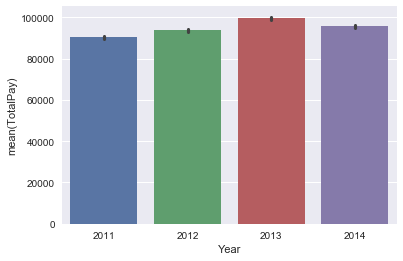

In [229]:
# Average Paid by year
sf[['Year', "TotalPay"]].groupby('Year').mean()
sns.barplot(x = "Year", y="TotalPay", data = sf)

In [230]:
#Total paid to San Francisco city employees in years 2011 - 2014

print('Total Paid in four years:')

sf['TotalPay'].sum()

Total Paid in four years:


6098935280.970019

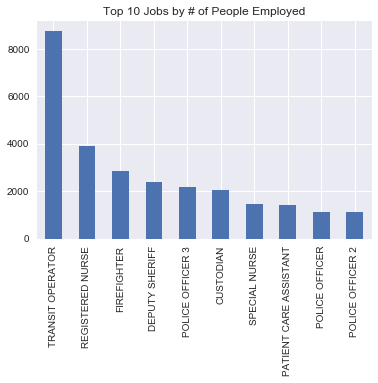

In [231]:
JobTitleCount = sf['JobTitle'].value_counts().head(10)
JobTitleCount.plot(title = "Top 10 Jobs by # of People Employed", kind = 'bar')

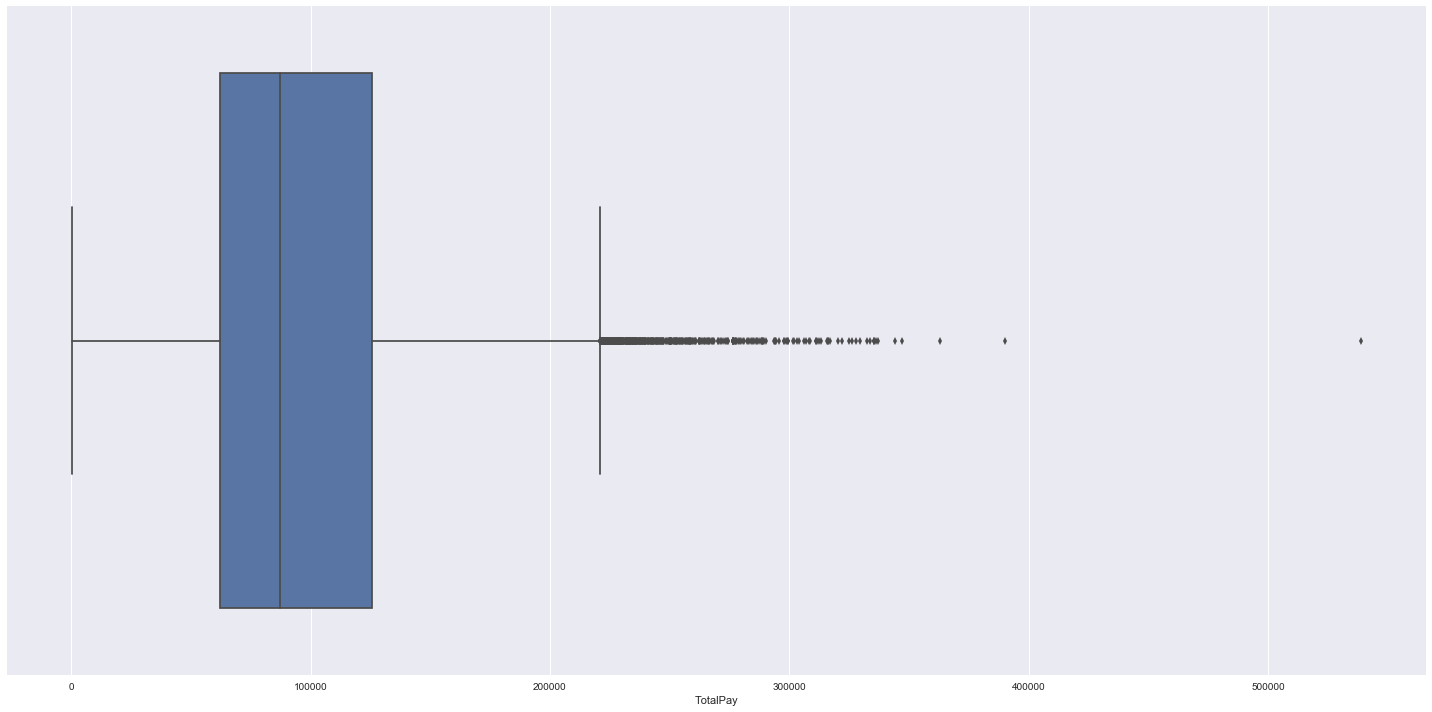

In [232]:
PayByYear = sns.FacetGrid(sf, size=10, aspect=2)
PayByYear = PayByYear.map(sns.boxplot, "TotalPay")

# If this tells us anything, is that there are some extreme outliers.

We can clearly see that there are some extreme outliers in this dataset.

Lets seperate the "High" and "Low" earners to look at them in greater detail.

Above we see the 'JobTitles' and 'EmployeeNames' of the "High Earners", we additionally learn that many of them hold the position for more than one year.

We also see that JobTitles were slightly changed between years, and as a result the same jobs appear seperately, lets create a new field called 'Department' later to hone in and compare departments.

There is also the addition of a middle name initial which is creating duplication in data.

In [233]:
# Create a new column called 'Department'
sf['Department'] = ''

When looking at the 'JobTitles' it is clear that employees can be grouped easily into certain departments such as below:

In [234]:
sf.loc[sf.JobTitle.str.contains('POLICE'), 'Department'] = "POLICE"
sf.loc[sf.JobTitle.str.contains("FIRE"), 'Department'] = "FIRE"
sf.loc[sf.JobTitle.str.contains("MEDICAL"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("NURSE"), 'Department'] = "MEDICAL"
sf.loc[sf.JobTitle.str.contains("TRANSIT"), 'Department'] = "TRANSIT"

In [235]:
# Applying $ (currency) for formatting and attractive presentation

ByDepartment = pd.pivot_table(sf, index=['Department'], values=["TotalPay"], aggfunc=[np.sum, np.mean, len], fill_value=0)
ByDepartment.ix[:,0] = ['${:,.2f} MM'.format(x) for x in ByDepartment.ix[:,0]/1000000]
ByDepartment.ix[:,1] = ['${:,.2f}'.format(x) for x in ByDepartment.ix[:,1]]
ByDepartment

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,sum,mean,len
,TotalPay,TotalPay,TotalPay
Department,,,
,"$2,799.85 MM","$83,010.20",33729
FIRE,$845.95 MM,"$158,270.02",5345
MEDICAL,$681.67 MM,"$98,407.36",6927
POLICE,$942.44 MM,"$128,766.14",7319
TRANSIT,$829.02 MM,"$75,427.52",10991


In the above table we can see the total, mean and count of Total Paid per Department

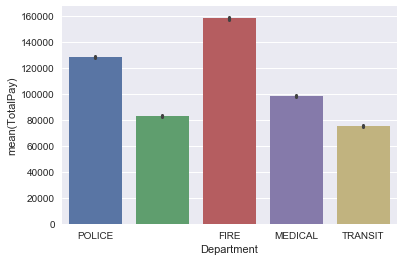

In [236]:
sns.barplot(x = "Department", y = "TotalPay", data = sf)

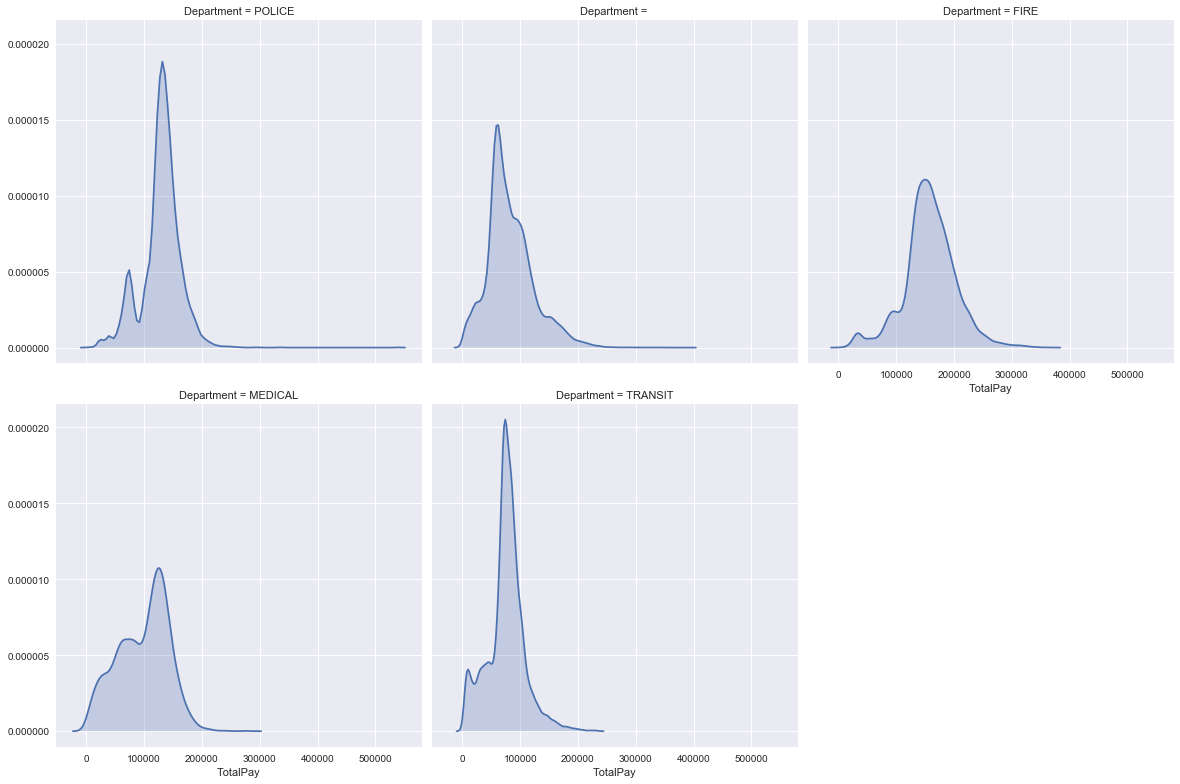

In [237]:
plot_jg = sns.FacetGrid(sf, col="Department", col_wrap=3, size=5.5, dropna=True)
plot_jg = plot_jg.map(sns.kdeplot, 'TotalPay', shade=True)

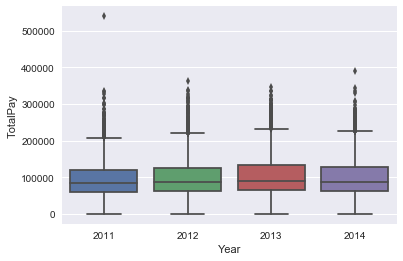

In [238]:
sns.boxplot(x="Year", y="TotalPay", data=sf)

Above we see that the salaries have not changed between the years.

# Difference in earning between genders

In [239]:
# from https://pypi.python.org/pypi/gender-guesser
import gender_guesser.detector as gender

In [240]:
d = gender.Detector(case_sensitive=False)

In [241]:
sf['FirstName'] = sf.EmployeeName.str.split(' ').str.get(0)
sf['FirstName']= sf.FirstName.str.lower()
sf.FirstName.fillna(method="backfill", inplace=True)

In [242]:
gender = []
names = []

for i in range(0, len(sf.FirstName)):
    names.append(sf.FirstName.iloc[i])
    gender.append(d.get_gender(sf.FirstName.iloc[i]))

In [243]:
# Create gender dataset

dict_gender = dict(zip(names, gender))
df_gender = pd.DataFrame()
df_gender['FirstName'] = dict_gender.keys()
df_gender['Gender'] = dict_gender.values()
sf_gender = pd.merge(sf, df_gender, how='left')
sf_gender.head(10)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [265]:
# Clean up the genders to fall into categories

sf_gender.ix[sf_gender['Gender'] == 'andy', 'Gender'] = 'unknown'
sf_gender.ix[sf_gender['Gender'] == 'mostly_female', 'Gender'] = 'female'
sf_gender.ix[sf_gender['Gender'] == 'mostly_male', 'Gender'] = 'male'
sf_gender.head(10)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,Year,Status,Department,FirstName,Gender
0,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,2011,NaN,POLICE,gary,male
1,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,2011,NaN,POLICE,albert,male
2,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,2011,NaN,,christopher,male
3,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,2011,NaN,FIRE,patrick,male
4,6,DAVID SULLIVAN,ASSISTANT DEPUTY CHIEF II,118602.00,8601.00,189082.74,NaN,316285.74,2011,NaN,,david,male
5,7,ALSON LEE,"BATTALION CHIEF, (FIRE DEPARTMENT)",92492.01,89062.90,134426.14,NaN,315981.05,2011,NaN,FIRE,alson,unknown
6,9,MICHAEL MORRIS,"BATTALION CHIEF, (FIRE DEPARTMENT)",176932.64,86362.68,40132.23,NaN,303427.55,2011,NaN,FIRE,michael,male
7,11,ARTHUR KENNEY,"ASSISTANT CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)",194999.39,71344.88,33149.90,NaN,299494.17,2011,NaN,FIRE,arthur,male
8,12,PATRICIA JACKSON,CAPTAIN III (POLICE DEPARTMENT),99722.00,87082.62,110804.30,NaN,297608.92,2011,NaN,POLICE,patricia,female
9,15,DAVID FRANKLIN,"BATTALION CHIEF, (FIRE DEPARTMENT)",174872.64,74050.30,37424.11,NaN,286347.05,2011,NaN,FIRE,david,male


In [253]:
dept_gender = sf_gender.groupby(['Gender', 'Department']).size().unstack()
dept_gender

Department,,FIRE,MEDICAL,POLICE,TRANSIT
Gender,,,,,
female,8667,786,4332,1164,1868
male,20261,4294,1383,5734,7286
unknown,4801,265,1212,421,1837


Here we can see that there are significantly less female's on the job except in the MEDICAL profession.

In [39]:
# Can you compare two related quantities?

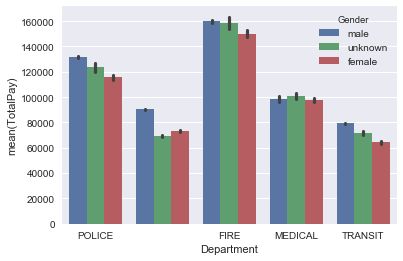

In [260]:
sns.barplot(data=sf_gender, x='Department', y='TotalPay', hue='Gender')

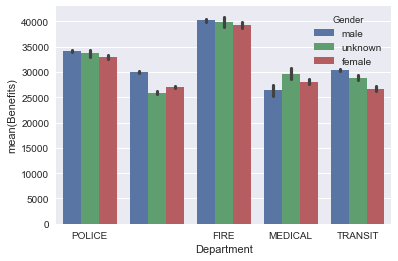

In [261]:
sns.barplot(data=sf_gender, x='Department', y='Benefits', hue='Gender')

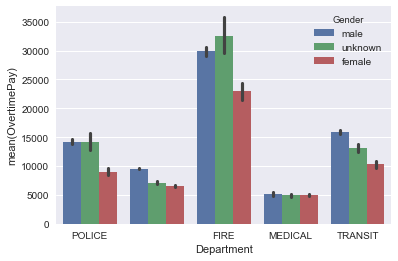

In [263]:
sns.barplot(data=sf_gender, x='Department', y='OvertimePay', hue='Gender')

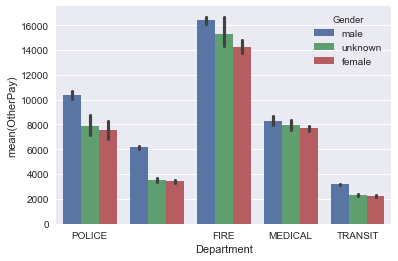

In [264]:
sns.barplot(data=sf_gender, x='Department', y='OtherPay', hue='Gender')

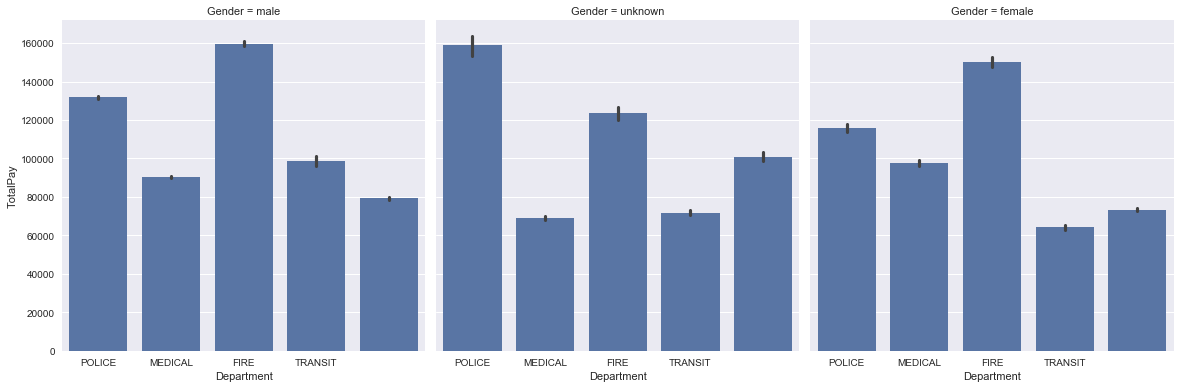

In [284]:
plot_gen = sns.FacetGrid(sf_gender, col="Gender", col_wrap=3, size=5.5, dropna=True)
plot_gen = plot_gen.map(sns.barplot, 'Department', 'TotalPay')

In [43]:
# Can you make a scatterplot?

In [44]:
# Can you make a time-series plot?

In [45]:
# How have salaries changed over time between different groups of people?

In [46]:
# How are base pay, overtime pay and benefits allocated between different groups?

In [47]:
# Can we split the dataset between males and females?

In [48]:
# Is there any evidene of pay discrimination based on gender in this dataset?

In [255]:
sf_male = sf_gender[sf_gender['Gender'] == 'male']
#sf_male.pivot(columns=['Department','TotalPay'])

pd.pivot_table(sf_gender, index=['Gender', 'Department'], values=["TotalPay"], aggfunc=[np.max,np.mean, len], fill_value=0)

amax           mean      len
                     TotalPay       TotalPay TotalPay
Gender  Department                                   
female              390111.98   73434.247812     8667
        FIRE        301697.70  150011.716743      786
        MEDICAL     274550.25   97633.275226     4332
        POLICE      297608.92  115792.121976     1164
        TRANSIT     230239.98   64349.281162     1868
male                332343.61   90402.405422    20261
        FIRE        362844.66  159751.367089     4294
        MEDICAL     278569.21   98714.565177     1383
        POLICE      538909.28  131786.902499     5734
        TRANSIT     233464.63   79178.455913     7286
unknown             336393.73   69100.847957     4801
        FIRE        315981.05  158761.069094      265
        MEDICAL     221930.95  100823.603375     1212
        POLICE      224813.84  123494.634014      421
        TRANSIT     223103.44   71815.584594     1837

In [49]:
# How is budget allocated based on different groups and responsibilities?

In [50]:
# Any 80/20 principals I can identify?

In [51]:
# Integrate ideas from here:
# https://public.tableau.com/profile/lawrence.chernin#!/vizhome/SanFranciscoSalaries/CountsbyTitle

## Questions to Explore

In [33]:
# Are there any duplicate names in the dataset?

In [34]:
# Which employee has been employed three years?

In [35]:
# What is the correlation between titles and salaries?